In [1]:
# Dependancies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras_tuner as kt
import os
import cv2
import imghdr

/var/folders/z8/8h1hp18s6b7_1dkb8123z9j80000gn/T/ipykernel_62108/3226401848.py:11: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

# Import data

Import data from sql database

In [3]:
# remove invalid image formats from the data

dir_path = 'dataset'
image_exts = ['jpg', 'jpeg', 'bmp', 'png']

for image_class in os.listdir(dir_path):
    class_path = os.path.join(dir_path, image_class)
    if os.path.isdir(class_path):  
        for image in os.listdir(class_path):
            image_path = os.path.join(class_path, image)
            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print(f'Image {image} is a {tip} file')
                    os.remove(image_path)
            except:
                print(f'Image {image} is not a valid image file')
                # os.remove(image_path)

In [4]:
# tf.data.Dataset.list_files??
# tf.keras.utils.image_dataset_from_directory??

In [5]:
# load in data
dataset = tf.keras.utils.image_dataset_from_directory('dataset')

Found 1460 files belonging to 2 classes.


In [6]:
# access the data pipeline
data_iter = dataset.as_numpy_iterator()
batch = data_iter.next()

In [7]:
# batch is a tuple of (images, image_labels) in groups of 20
print(len(batch[0]))
# print(batch[0])
print(len(batch[1]))
print(batch[1])
print(batch[0].shape)
print(batch[1].shape)

32
32
[0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0 0 1 0 1 0 1]
(32, 256, 256, 3)
(32,)


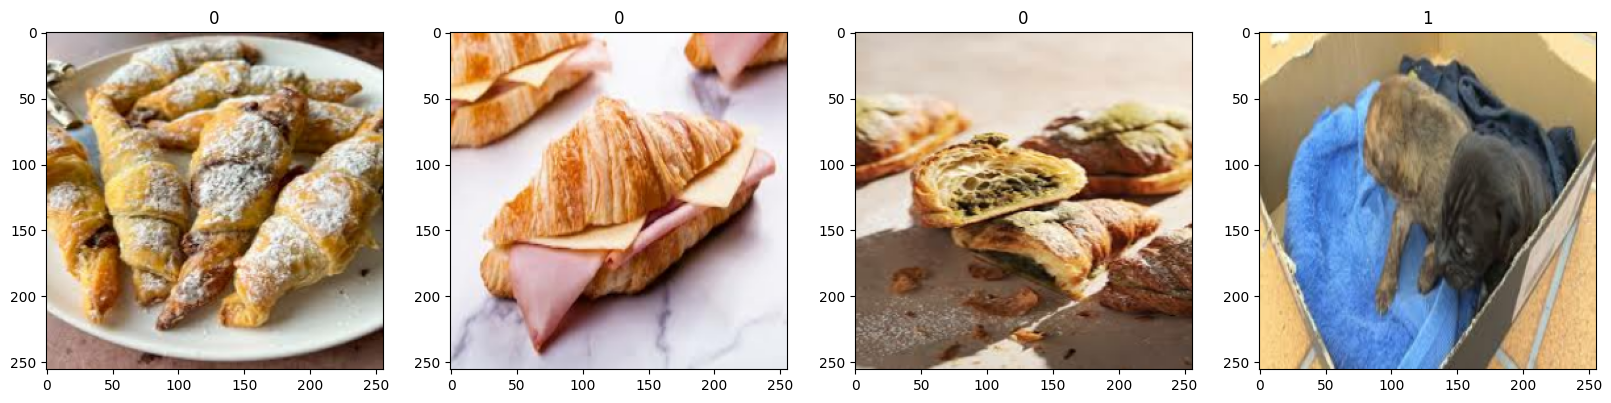

In [8]:
# have a look to see how the data is labelled
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Shar-Peis are 1

Croissants are 0

In [9]:
# # code for one image
# img = cv2.imread('practice_data/sharpei/Chinese-Shar-Pei-Puppy-1.jpg')
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.show()
# img.shape

# Preprocess data

insure same pixel size / kernels
scale the data
? features and targets
split into test and training

Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [10]:
# scale the data so images are between 0 and 1
# current scale of practice dataset (20, 256, 256, 3)

# # Principle: scale the data by dividing by the max value
# scaled = batch[0] / batch[0].max()
# scaled.max()

# apply the above principle to all the data
scaled_data = dataset.map(lambda x, y: (x/255, y))

In [11]:
scaled_data_iter = scaled_data.as_numpy_iterator()
batch_scaled = scaled_data_iter.next()

In [12]:
print(batch_scaled[0].max())
print(batch_scaled[0].min())

1.0
0.0


### Split into test and training
https://www.youtube.com/watch?v=jztwpsIzEGc

In [13]:
# determine size of test, validation and training data
train_size = int(0.7 * len(scaled_data))
val_size = int(0.2 * len(scaled_data))
test_size = int(0.1 * len(scaled_data))
print(train_size, val_size, test_size)
print(train_size + val_size + test_size)

32 9 4
45


In [14]:
# split the data
train = dataset.take(train_size)
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size + val_size).take(test_size)

In [15]:
print(len(train), len(val), len(test))

32 9 4


# Build the CNN Model

Build the deep learning model using the keras sequential API

Architecture / layers:
- input (n=data)
- dense layers (activation relu)
- output layer (activate sigmoid) - croissant or pug

Using relu activation (preserves the positive values)
and sigmoid activation for final output layer

Compile using adam optomiser

In [16]:
# first layer is convolutional layer
model = Sequential()

# input convolutional layer (non training)
model.add(Conv2D(32, (3, 3), strides=1, activation='relu', input_shape=(256, 256, 3))) # 32 filters, 1 stride (i.e. look at 1 pixel at a time), 3x3 kernel, 256x256x3 input shape
model.add(MaxPooling2D((2, 2))) # 2x2 max pooling layer (takes max value from 2x2 area to condense information)

# layer 1
model.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D((2, 2)))

# layer 2
model.add(Conv2D(32, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D((2, 2)))

# flatten the data
model.add(Flatten())

# output layer - dense layer (i.e. fully connected)
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [17]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
# summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     7,373,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,411,169 (28.27 MB)

 Trainable params: 7,411,169 (28.27 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [19]:
# track change sin the model performance
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [20]:
# fit the model using the training dataset, validate using the validation dataset, and track performance in logs
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 390ms/step - accuracy: 0.5424 - loss: 100.0986 - val_accuracy: 0.6458 - val_loss: 0.6424
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 384ms/step - accuracy: 0.7203 - loss: 0.5775 - val_accuracy: 0.7708 - val_loss: 0.4297
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 387ms/step - accuracy: 0.8442 - loss: 0.3698 - val_accuracy: 0.7674 - val_loss: 0.5004
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 374ms/step - accuracy: 0.9147 - loss: 0.2489 - val_accuracy: 0.7604 - val_loss: 0.5792
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 378ms/step - accuracy: 0.9190 - loss: 0.1789 - val_accuracy: 0.8507 - val_loss: 0.3678
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 377ms/step - accuracy: 0.9571 - loss: 0.1219 - val_accuracy: 0.7951 - val_loss: 0.5744
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 373ms/step - accuracy: 0.9122 - loss: 0.2524 - val_accuracy: 0.8681 - val_loss: 0.4003
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 373ms/step - accuracy: 0.9741 - loss: 0.1165 - val_ac

In [21]:
# look at model performance history
hist.history

{'accuracy': [0.587890625,
  0.736328125,
  0.8525390625,
  0.9296875,
  0.9091796875,
  0.9404296875,
  0.916015625,
  0.9619140625,
  0.9697265625,
  0.84375,
  0.904296875,
  0.9521484375,
  0.9736328125,
  0.96484375,
  0.951171875,
  0.966796875,
  0.9404296875,
  0.931640625,
  0.9697265625,
  0.958984375],
 'loss': [36.1731071472168,
  0.5605955123901367,
  0.3414398729801178,
  0.20670896768569946,
  0.21770788729190826,
  0.17205865681171417,
  0.24721728265285492,
  0.1407342106103897,
  0.12658599019050598,
  0.5418680310249329,
  0.27764463424682617,
  0.15780077874660492,
  0.09750563651323318,
  0.1656293421983719,
  0.1729862093925476,
  0.14193379878997803,
  0.18024085462093353,
  0.18957480788230896,
  0.08652999997138977,
  0.12228840589523315],
 'val_accuracy': [0.6458333134651184,
  0.7708333134651184,
  0.7673611044883728,
  0.7604166865348816,
  0.8506944179534912,
  0.7951388955116272,
  0.8680555820465088,
  0.9236111044883728,
  0.90625,
  0.8125,
  0.90625,
 

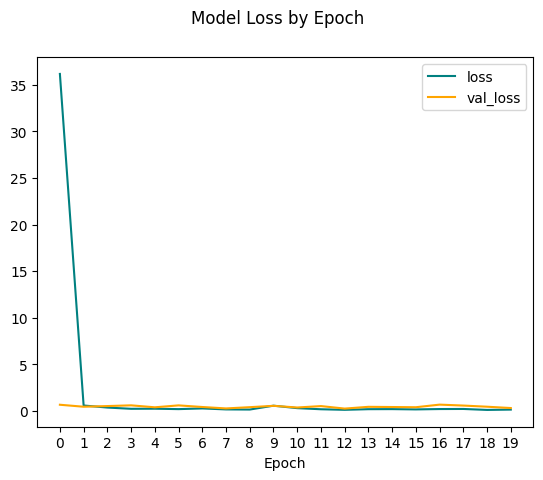

In [22]:
# plot performance - data loss by epoch
fig = plt.figure()
plt.plot(hist.history['loss'], label='loss', color='teal')
plt.plot(hist.history['val_loss'], label='val_loss', color='orange')
fig.suptitle('Model Loss by Epoch')
plt.xticks(np.arange(0, 20, 1))
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

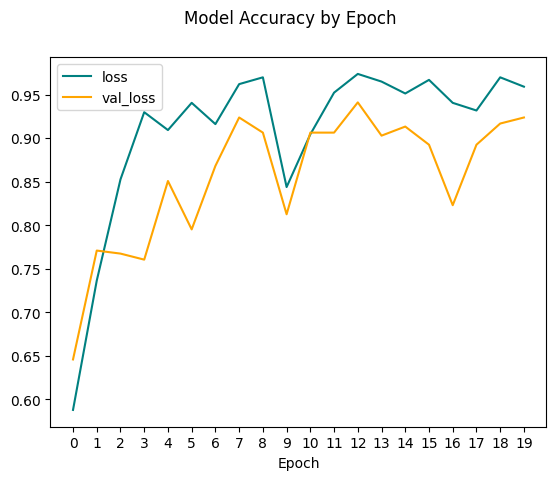

In [23]:
# plot performance - accuracy by epoch
fig = plt.figure()
plt.plot(hist.history['accuracy'], label='loss', color='teal')
plt.plot(hist.history['val_accuracy'], label='val_loss', color='orange')
fig.suptitle('Model Accuracy by Epoch')
plt.legend(loc='upper left')
plt.xticks(np.arange(0, 20, 1))
plt.xlabel('Epoch')
plt.show()

# Evaluate the performance of the model

Assess precision, recall and accuracy

In [24]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [25]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [26]:
len(test)

4

In [27]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    # y is y true value and yhat is y predicted value
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


2024-03-14 21:22:57.116435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [28]:
print(f"""
precision = {precision.result().numpy()}
recall = {recall.result().numpy()}
accuracy = {accuracy.result().numpy()}
""")


precision = 0.9200000166893005
recall = 0.8679245114326477
accuracy = 0.9140625



for deeper understanding can use a confusion matrix

# Test n=1 new shar pei

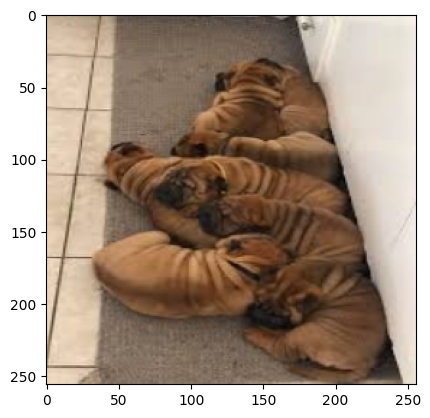

In [29]:
unseen_sharpei = cv2.imread('unseen_sharpei_test.jpeg')
# resize and colour correct image
resized_unseen_sharpei = tf.image.resize(unseen_sharpei, (256, 256)).numpy().astype(int)[:, :, ::-1]
plt.imshow(resized_unseen_sharpei)
plt.show()

In [62]:
yhat = model.predict(np.expand_dims(resized_unseen_sharpei/255, axis=0))
print(yhat)
print('It is a Sharpei' if yhat > 0.5 else 'It is a croissant')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.7697839]]
It is a Sharpei


# Test n=1 new croissant 

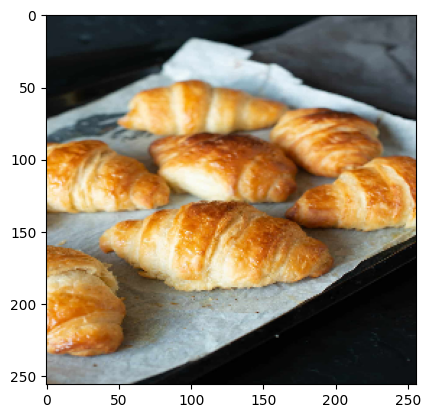

In [31]:
unseen_croissant = cv2.imread('unseen_croissant_test.jpeg')
# resize and colour correct image
resized_unseen_croissant = tf.image.resize(unseen_croissant, (256, 256)).numpy().astype(int)[:, :, ::-1]
plt.imshow(resized_unseen_croissant)
plt.show()

In [63]:
yhat = model.predict(np.expand_dims(resized_unseen_croissant/255, axis=0))
print(yhat)
print('It is a shar-pei' if yhat > 0.5 else 'It is a croissant')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[[0.7133227]]
It is a shar-pei


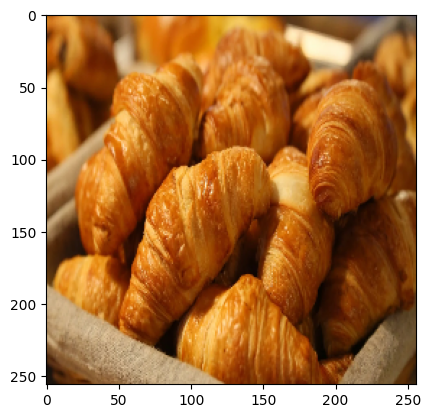

In [33]:
unseen_croissant2 = cv2.imread('unseen_croissant_test2.jpeg')
# resize and colour correct image
resized_unseen_croissant2 = tf.image.resize(unseen_croissant2, (256, 256)).numpy().astype(int)[:, :, ::-1]
plt.imshow(resized_unseen_croissant2)
plt.show()

In [64]:
yhat = model.predict(np.expand_dims(resized_unseen_croissant2/255, axis=0))
print(yhat)
print('It is a shar-pei' if yhat > 0.5 else 'It is a croissant')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.54450256]]
It is a shar-pei


# Model is not performing well

Test and training data are too skewed towards images of shar peis alone, and croissants as a bunch of croissants.

Need to change the data set for better training and testing.

Data set 2 will have images from:
- shar pei search (original)
- group of shar peis search (added)
- croissants search (original)
- singular croissant search (added)

Found 1566 files belonging to 2 classes.


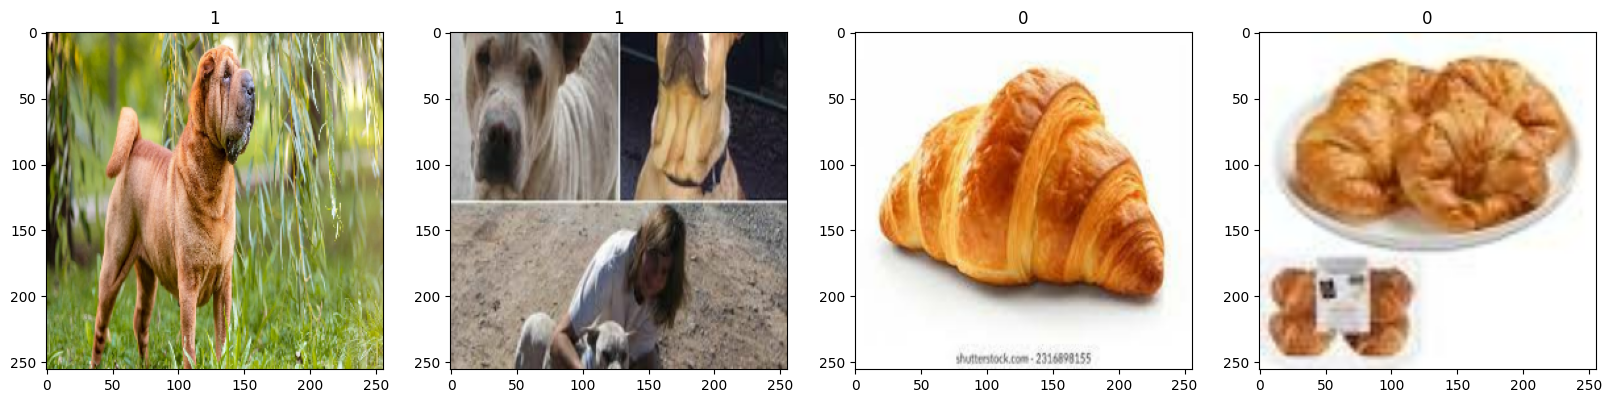

In [35]:
# dataset2

# remove invalid image formats from the data

dir_path2 = 'dataset2'
image_exts = ['jpg', 'jpeg', 'bmp', 'png']

for image_class in os.listdir(dir_path2):
    class_path = os.path.join(dir_path2, image_class)
    if os.path.isdir(class_path):  
        for image in os.listdir(class_path):
            image_path = os.path.join(class_path, image)
            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print(f'Image {image} is a {tip} file')
                    os.remove(image_path)
            except:
                print(f'Image {image} is not a valid image file')
                # os.remove(image_path)

dataset2 = tf.keras.utils.image_dataset_from_directory('dataset2')

# access the data pipeline
data_iter2 = dataset2.as_numpy_iterator()
batch2 = data_iter2.next()

# have a look to see how the data is labelled
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch2[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch2[1][idx])

In [36]:
# Preprocessing
scaled_data2 = dataset2.map(lambda x, y: (x/255, y))

# determine size of test, validation and training data
train_size2 = int(0.7 * len(scaled_data2))
val_size2 = int(0.2 * len(scaled_data2))
test_size2 = int(0.1 * len(scaled_data2))
print(train_size2, val_size2, test_size2)
print(train_size2 + val_size2 + test_size2)

# split the data
train2 = dataset2.take(train_size2)
val2 = dataset2.skip(train_size2).take(val_size2)
test2 = dataset2.skip(train_size2 + val_size2).take(test_size2)

print(len(train2), len(val2), len(test2))

34 9 4
47
34 9 4


In [37]:
# build model

model2 = Sequential()
# input convolutional layer (non training)
model2.add(Conv2D(32, (3, 3), strides=1, activation='relu', input_shape=(256, 256, 3))) # 32 filters, 1 stride (i.e. look at 1 pixel at a time), 3x3 kernel, 256x256x3 input shape
model2.add(MaxPooling2D((2, 2))) # 2x2 max pooling layer (takes max value from 2x2 area to condense information)

# layer 1
model2.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
model2.add(MaxPooling2D((2, 2)))

# layer 2
model2.add(Conv2D(32, (3, 3), strides=1, activation='relu'))
model2.add(MaxPooling2D((2, 2)))

# flatten the data
model2.add(Flatten())

# output layer - dense layer (i.e. fully connected)
model2.add(Dense(256, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

# compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# summary
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     7,373,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,411,169 (28.27 MB)

 Trainable params: 7,411,169 (28.27 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# track change sin the model performance
logdir = 'logs'
tensorboard_callback2 = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# fit the model using the training dataset, validate using the validation dataset, and track performance in logs
hist2 = model2.fit(train2, epochs=20, validation_data=val2, callbacks=[tensorboard_callback])

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 390ms/step - accuracy: 0.6111 - loss: 178.9131 - val_accuracy: 0.5417 - val_loss: 0.7434
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 388ms/step - accuracy: 0.6504 - loss: 0.6126 - val_accuracy: 0.6701 - val_loss: 0.5982
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 382ms/step - accuracy: 0.8046 - loss: 0.4388 - val_accuracy: 0.8090 - val_loss: 0.5520
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 385ms/step - accuracy: 0.8682 - loss: 0.3521 - val_accuracy: 0.8090 - val_loss: 0.5146
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 386ms/step - accuracy: 0.9146 - loss: 0.2624 - val_accuracy: 0.8229 - val_loss: 0.5502
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 385ms/step - accuracy: 0.9518 - loss: 0.1640 - val_accuracy: 0.8785 - val_loss: 0.4672
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 384ms/step - accuracy: 0.9796 - loss: 0.0787 - val_accuracy: 0.8576 - val_loss: 0.5787
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 385ms/step - accuracy: 0.9814 - loss: 0.0752 - val_ac

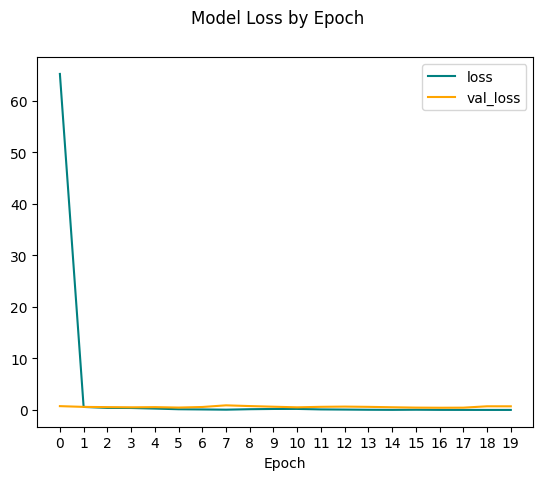

In [39]:
# plot performance - data loss by epoch
fig = plt.figure()
plt.plot(hist2.history['loss'], label='loss', color='teal')
plt.plot(hist2.history['val_loss'], label='val_loss', color='orange')
fig.suptitle('Model Loss by Epoch')
plt.xticks(np.arange(0, 20, 1))
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

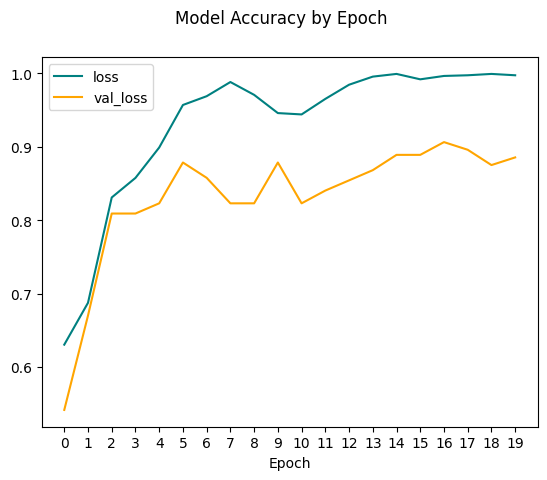

In [40]:
# plot performance - accuracy by epoch
fig = plt.figure()
plt.plot(hist2.history['accuracy'], label='loss', color='teal')
plt.plot(hist2.history['val_accuracy'], label='val_loss', color='orange')
fig.suptitle('Model Accuracy by Epoch')
plt.legend(loc='upper left')
plt.xticks(np.arange(0, 20, 1))
plt.xlabel('Epoch')
plt.show()

In [41]:
# evaluate the model
precision2 = Precision()
recall2 = Recall()
accuracy2 = BinaryAccuracy()

for batch2 in test2.as_numpy_iterator():
    X2, y2 = batch2
    yhat2 = model2.predict(X2)
    # y is y true value and yhat is y predicted value
    precision2.update_state(y2, yhat2)
    recall2.update_state(y2, yhat2)
    accuracy2.update_state(y2, yhat2)

    print(f"""
precision = {precision2.result().numpy()}
recall = {recall2.result().numpy()}
accuracy = {accuracy2.result().numpy()}
""")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step

precision = 0.6666666865348816
recall = 0.9090909361839294
accuracy = 0.8125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

precision = 0.7307692170143127
recall = 0.949999988079071
accuracy = 0.875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

precision = 0.7560975551605225
recall = 0.8611111044883728
accuracy = 0.84375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

precision = 0.7321428656578064
recall = 0.8913043737411499
accuracy = 0.84375



2024-03-14 21:27:26.765506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Test new again

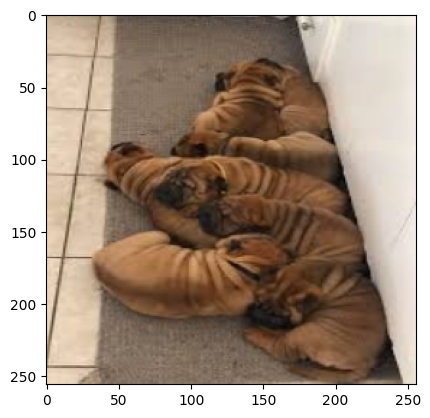

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.33034346]]
It is a croissant


In [61]:
unseen_sharpei = cv2.imread('unseen_sharpei_test.jpeg')
# resize and colour correct image
resized_unseen_sharpei = tf.image.resize(unseen_sharpei, (256, 256)).numpy().astype(int)[:, :, ::-1]
plt.imshow(resized_unseen_sharpei)
plt.show()
yhat = model2.predict(np.expand_dims(resized_unseen_sharpei/255, axis=0))
print(yhat)
print('It is a Sharpei' if yhat > 0.5 else 'It is a croissant')

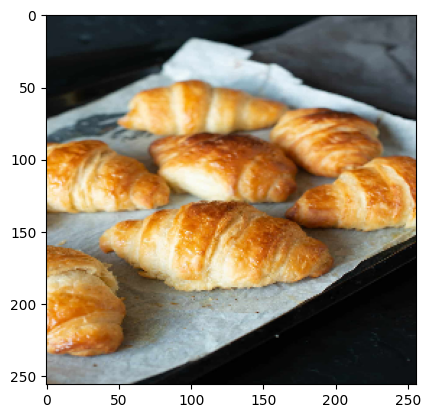

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.3380094]]
It is a croissant


In [59]:
unseen_croissant = cv2.imread('unseen_croissant_test.jpeg')
# resize and colour correct image
resized_unseen_croissant = tf.image.resize(unseen_croissant, (256, 256)).numpy().astype(int)[:, :, ::-1]
plt.imshow(resized_unseen_croissant)
plt.show()
yhat = model2.predict(np.expand_dims(resized_unseen_croissant/255, axis=0))
print(yhat)
print('It is a shar-pei' if yhat > 0.5 else 'It is a croissant')

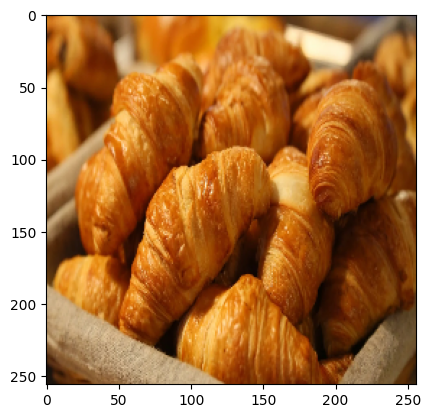

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[0.31880188]]
It is a croissant


In [57]:
unseen_croissant2 = cv2.imread('unseen_croissant_test2.jpeg')
# resize and colour correct image
resized_unseen_croissant2 = tf.image.resize(unseen_croissant2, (256, 256)).numpy().astype(int)[:, :, ::-1]
plt.imshow(resized_unseen_croissant2)
plt.show()
yhat = model2.predict(np.expand_dims(resized_unseen_croissant2/255, axis=0))
print(yhat)
print('It is a shar-pei' if yhat > 0.5 else 'It is a croissant')

# Is the model just overfitted?
train for 10 epochs

In [49]:
# build model

model3 = Sequential()
# input convolutional layer (non training)
model3.add(Conv2D(32, (3, 3), strides=1, activation='relu', input_shape=(256, 256, 3))) # 32 filters, 1 stride (i.e. look at 1 pixel at a time), 3x3 kernel, 256x256x3 input shape
model3.add(MaxPooling2D((2, 2))) # 2x2 max pooling layer (takes max value from 2x2 area to condense information)

# layer 1
model3.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
model3.add(MaxPooling2D((2, 2)))

# layer 2
model3.add(Conv2D(32, (3, 3), strides=1, activation='relu'))
model3.add(MaxPooling2D((2, 2)))

# flatten the data
model3.add(Flatten())

# output layer - dense layer (i.e. fully connected)
model3.add(Dense(256, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

# compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# summary
model3.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     7,373,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,411,169 (28.27 MB)

 Trainable params: 7,411,169 (28.27 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# track change sin the model performance
logdir = 'logs'
tensorboard_callback3 = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# fit the model using the training dataset, validate using the validation dataset, and track performance in logs
hist3 = model3.fit(train2, epochs=15, validation_data=val2, callbacks=[tensorboard_callback3])

Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 394ms/step - accuracy: 0.9717 - loss: 0.0753 - val_accuracy: 0.9097 - val_loss: 0.3952
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 390ms/step - accuracy: 0.9824 - loss: 0.0450 - val_accuracy: 0.8681 - val_loss: 0.8477
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 400ms/step - accuracy: 0.9852 - loss: 0.0475 - val_accuracy: 0.9236 - val_loss: 0.5078
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 402ms/step - accuracy: 0.9835 - loss: 0.0262 - val_accuracy: 0.9306 - val_loss: 0.3929
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 395ms/step - accuracy: 0.9878 - loss: 0.0182 - val_accuracy: 0.9444 - val_loss: 0.5444
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 396ms/step - accuracy: 0.9855 - loss: 0.0214 - val_accuracy: 0.9340 - val_loss: 0.4462
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 387ms/step - accuracy: 0.9913 - loss: 0.0134 - val_accuracy: 0.9583 - val_loss: 0.4276
Epoch 8/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 392ms/step - accuracy: 0.9793 - loss: 0.0668 - val_accu

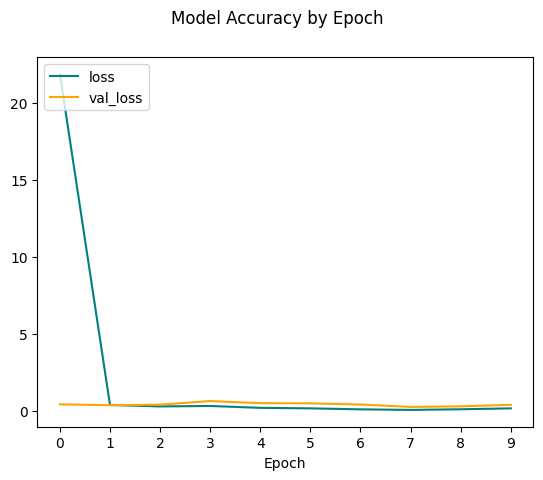

In [53]:
# plot performance - accuracy by epoch
fig = plt.figure()
plt.plot(hist3.history['loss'], label='loss', color='teal')
plt.plot(hist3.history['val_loss'], label='val_loss', color='orange')
fig.suptitle('Model Accuracy by Epoch')
plt.legend(loc='upper left')
plt.xticks(np.arange(0, 10, 1))
plt.xlabel('Epoch')
plt.show()

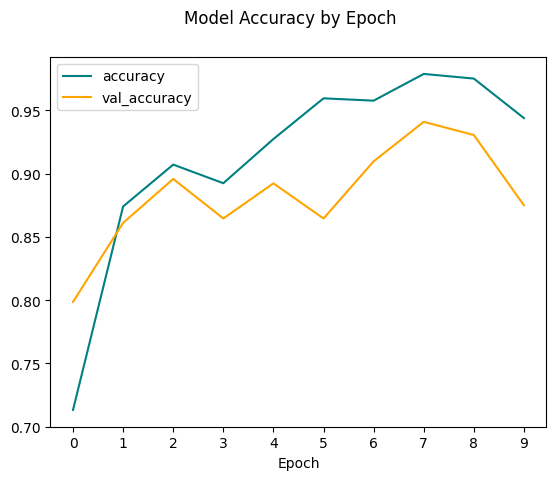

In [54]:
# plot performance - accuracy by epoch
fig = plt.figure()
plt.plot(hist3.history['accuracy'], label='accuracy', color='teal')
plt.plot(hist3.history['val_accuracy'], label='val_accuracy', color='orange')
fig.suptitle('Model Accuracy by Epoch')
plt.legend(loc='upper left')
plt.xticks(np.arange(0, 10, 1))
plt.xlabel('Epoch')
plt.show()

In [55]:
# evaluate the model
precision3 = Precision()
recall3 = Recall()
accuracy3 = BinaryAccuracy()

for batch in test2.as_numpy_iterator():
    X, y = batch
    yhat3 = model3.predict(X)
    # y is y true value and yhat is y predicted value
    precision3.update_state(y, yhat)
    recall3.update_state(y, yhat)
    accuracy3.update_state(y, yhat)

    print(f"""
precision = {precision3.result().numpy()}
recall = {recall3.result().numpy()}
accuracy = {accuracy3.result().numpy()}
""")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

precision = 0.34375
recall = 1.0
accuracy = 0.34375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

precision = 0.359375
recall = 1.0
accuracy = 0.359375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

precision = 0.375
recall = 1.0
accuracy = 0.375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

precision = 0.375
recall = 1.0
accuracy = 0.375



2024-03-15 10:05:59.251186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


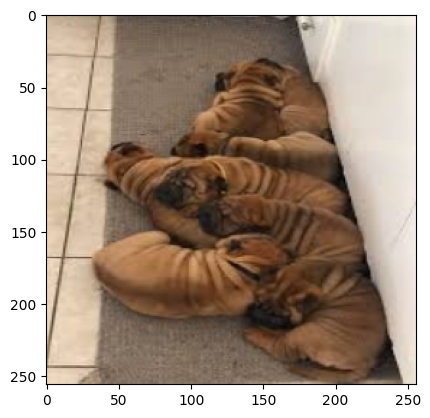

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[0.57668]]
It is a Sharpei


In [65]:
unseen_sharpei = cv2.imread('unseen_sharpei_test.jpeg')
# resize and colour correct image
resized_unseen_sharpei = tf.image.resize(unseen_sharpei, (256, 256)).numpy().astype(int)[:, :, ::-1]
plt.imshow(resized_unseen_sharpei)
plt.show()
yhat = model3.predict(np.expand_dims(resized_unseen_sharpei/255, axis=0))
print(yhat)
print('It is a Sharpei' if yhat > 0.5 else 'It is a croissant')

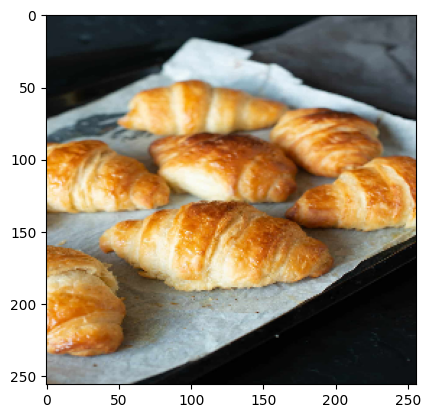

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[0.55818236]]
It is a shar-pei


In [56]:
unseen_croissant = cv2.imread('unseen_croissant_test.jpeg')
# resize and colour correct image
resized_unseen_croissant = tf.image.resize(unseen_croissant, (256, 256)).numpy().astype(int)[:, :, ::-1]
plt.imshow(resized_unseen_croissant)
plt.show()
yhat = model3.predict(np.expand_dims(resized_unseen_croissant/255, axis=0))
print(yhat)
print('It is a shar-pei' if yhat > 0.5 else 'It is a croissant')

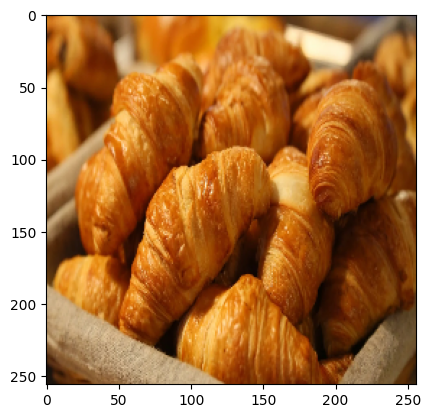

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[0.5046423]]
It is a shar-pei


In [66]:
unseen_croissant2 = cv2.imread('unseen_croissant_test2.jpeg')
# resize and colour correct image
resized_unseen_croissant2 = tf.image.resize(unseen_croissant2, (256, 256)).numpy().astype(int)[:, :, ::-1]
plt.imshow(resized_unseen_croissant2)
plt.show()
yhat = model3.predict(np.expand_dims(resized_unseen_croissant2/255, axis=0))
print(yhat)
print('It is a shar-pei' if yhat > 0.5 else 'It is a croissant')

# Confusion Matrix
https://www.youtube.com/watch?v=0LhiS6yu2qQ

In [48]:
import torch